# 01 — Exploratory Data Analysis and Dataset Understanding  
Hotel Booking Demand (Cancellation Prediction)

## Notebook purpose
This notebook provides exploratory data analysis (EDA) to:
- validate data quality (missing values, types, distributions)
- describe the target label distribution (`is_canceled`)
- identify candidate drivers of cancellations using report-ready plots and tables

## Inputs
- Preferred: `data/processed/hotel_bookings_dedup.csv`
- Fallback: `data/raw/hotel_bookings.csv`

## Outputs (overwritten on each run)
Outputs are written to a fixed artifact structure:
- `artifacts/data/` (tables and summaries)
- `artifacts/plots/` (figures)
- `artifacts/reports/` (report notes and reproducibility metadata)

No model training is performed in this notebook.


In [39]:
# Repository bootstrap (fixes ModuleNotFoundError: 'src')
# The repository root is resolved quickly using Git when available.
# A bounded parent-directory scan is used as a fallback.

import os
import sys
import subprocess
from pathlib import Path

def _find_repo_root(max_levels: int = 25) -> Path:
    # Fast path: Git repository root (works when the notebook is executed inside the repo)
    try:
        out = subprocess.check_output(
            ["git", "rev-parse", "--show-toplevel"],
            stderr=subprocess.DEVNULL,
            text=True,
        ).strip()
        p = Path(out)
        if (p / "src").is_dir():
            return p
    except Exception:
        pass

    # Fallback: bounded parent scan (prevents long scans on unusual paths)
    cwd = Path.cwd()
    candidates = [cwd] + list(cwd.parents)
    for p in candidates[:max_levels]:
        if (p / "src").is_dir():
            return p

    raise FileNotFoundError(
        "Folder 'src' was not found within the parent directories. "
        "Open the repository root folder in VS Code and rerun the notebook."
    )

root = _find_repo_root(max_levels=25)

os.chdir(root)
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

print("Working directory:", Path.cwd())
print("Python path entry added:", root)


Working directory: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment
Python path entry added: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment


## Imports and artifact folder initialization

The `artifacts/` folder is used as a fixed output location. Files are overwritten on each run to keep the latest outputs available.


In [40]:
import platform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Progress bar utilities for multi-column operations
try:
    from tqdm.auto import tqdm
except Exception:
    raise ImportError("Package 'tqdm' is required. Install with: pip install tqdm")

from src.config import PROJECT_NAME, RANDOM_STATE, TARGET_COL, DEFAULT_DATA_PATH, FIG_DPI
from src.data_loader import load_hotel_bookings, basic_train_ready_checks, summarize_dataframe
from src.io_utils import ensure_artifact_dirs, save_json, save_text, save_dataframe, save_run_metadata

ART = ensure_artifact_dirs("artifacts")

meta_path = save_run_metadata(
    {
        "project": PROJECT_NAME,
        "random_state": RANDOM_STATE,
        "target_col": TARGET_COL,
        "notebook": "01_eda_dataset_understanding.ipynb",
        "python_version": sys.version,
        "platform": platform.platform(),
    },
    base_dir="artifacts",
    repo_root=".",
)

print("Metadata file:", meta_path.resolve())
print("Artifacts base:", ART["base"].resolve())


Metadata file: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\reports\run_metadata.json
Artifacts base: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts


## Dataset loading

The processed dataset is preferred when available to standardize rows across team members.


In [41]:
from pathlib import Path

preferred_processed = Path("data/processed/hotel_bookings_dedup.csv")
preferred_raw = Path(DEFAULT_DATA_PATH)

dataset_path = preferred_processed if preferred_processed.exists() else preferred_raw
if not dataset_path.exists():
    raise FileNotFoundError("Dataset not found. Place the CSV at data/raw/hotel_bookings.csv")

print("Dataset path:", dataset_path.resolve())

df = load_hotel_bookings(dataset_path, drop_duplicates=False, verbose=True)
basic_train_ready_checks(df, target_col=TARGET_COL)

display(df.head())
display(pd.DataFrame({"rows": [df.shape[0]], "columns": [df.shape[1]]}))


Dataset path: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\data\processed\hotel_bookings_dedup.csv


[data_loader] Loaded shape: (87396, 32)
[data_loader] Columns: 32


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


,rows,columns
0,87396,32


## Overview tables

The following tables support report writing and later comparison:
- dataset summary (shape, dtypes, missing counts, target distribution)
- full missing-value table (counts and rates)
- target distribution table (counts and rates)


In [42]:
overview = summarize_dataframe(df, target_col=TARGET_COL)
save_json(overview, ART["data"] / "eda_overview.json")
print("Saved:", (ART["data"] / "eda_overview.json").resolve())

missing_full = (
    df.isna().sum()
      .sort_values(ascending=False)
      .reset_index()
)
missing_full.columns = ["column", "missing_count"]
missing_full["missing_rate"] = missing_full["missing_count"] / len(df)
save_dataframe(missing_full, ART["data"] / "missing_full.csv", index=False)
print("Saved:", (ART["data"] / "missing_full.csv").resolve())

target_dist = (
    df[TARGET_COL].value_counts()
      .rename_axis("label")
      .reset_index(name="count")
)
target_dist["rate"] = target_dist["count"] / target_dist["count"].sum()
save_dataframe(target_dist, ART["data"] / "target_distribution.csv", index=False)
print("Saved:", (ART["data"] / "target_distribution.csv").resolve())

display(target_dist)
display(missing_full.head(15))


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\data\eda_overview.json
Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\data\missing_full.csv
Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\data\target_distribution.csv


,label,count,rate
0,0,63371,0.725102
1,1,24025,0.274898


,column,missing_count,missing_rate
0,company,82137,0.939826
1,agent,12193,0.139514
2,country,452,0.005172
3,children,4,0.000046
4,arrival_date_month,0,0.000000
5,arrival_date_week_number,0,0.000000
6,hotel,0,0.000000
7,is_canceled,0,0.000000
8,stays_in_weekend_nights,0,0.000000
9,arrival_date_day_of_month,0,0.000000


## Target distribution figure

This figure shows class balance for the target label (`is_canceled`).


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\target_distribution.png


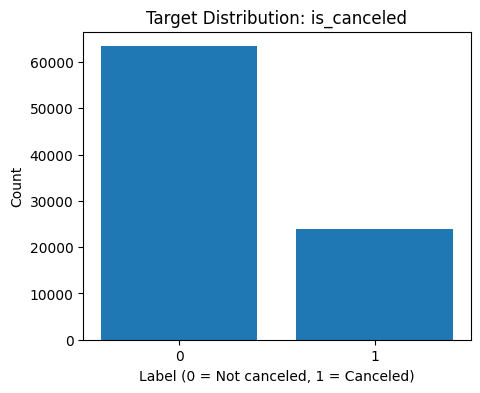

In [43]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(target_dist["label"].astype(str), target_dist["count"])
ax.set_title("Target Distribution: is_canceled")
ax.set_xlabel("Label (0 = Not canceled, 1 = Canceled)")
ax.set_ylabel("Count")

out_path = ART["plots"] / "target_distribution.png"
fig.savefig(out_path, dpi=FIG_DPI, bbox_inches="tight")
print("Saved:", out_path.resolve())

plt.show()
plt.close(fig)


## Missing values figure

This figure shows the top columns by missing value rate.


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\missing_rate_top15.png


,column,missing_count,missing_rate
7,is_canceled,0,0.000000
6,hotel,0,0.000000
5,arrival_date_week_number,0,0.000000
4,arrival_date_month,0,0.000000
11,stays_in_week_nights,0,0.000000
10,adults,0,0.000000
9,arrival_date_day_of_month,0,0.000000
8,stays_in_weekend_nights,0,0.000000
12,babies,0,0.000000
13,meal,0,0.000000


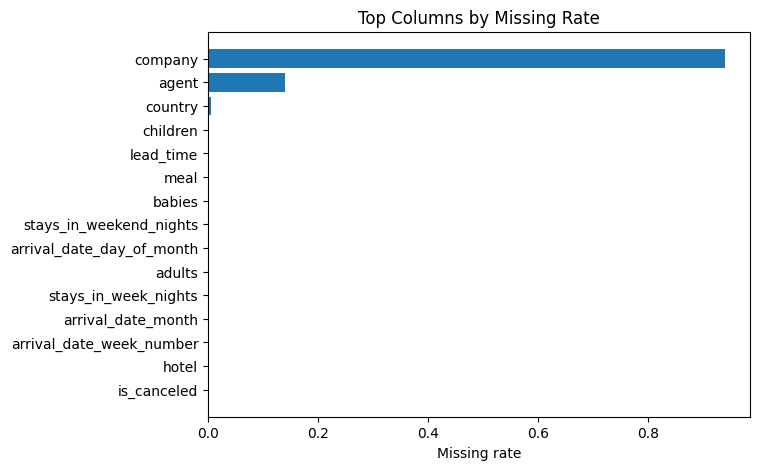

In [44]:
top_missing = missing_full.head(15).copy().sort_values("missing_rate", ascending=True)

fig, ax = plt.subplots(figsize=(7, 5))
ax.barh(top_missing["column"], top_missing["missing_rate"])
ax.set_title("Top Columns by Missing Rate")
ax.set_xlabel("Missing rate")

out_path = ART["plots"] / "missing_rate_top15.png"
fig.savefig(out_path, dpi=FIG_DPI, bbox_inches="tight")
print("Saved:", out_path.resolve())

display(top_missing)

plt.show()
plt.close(fig)


## Numeric feature summary and key distributions

Numeric summary statistics are saved to `artifacts/data/numeric_describe.csv`.
Histograms are generated for common high-signal numeric fields when present:
- `lead_time`
- `adr`
- `total_nights` (derived for EDA visualization)


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\data\numeric_describe.csv


,count,mean,std,min,25%,50%,75%,max
is_canceled,87396.0,0.274898,0.446466,0.0,0.0,0.0,1.0,1.0
lead_time,87396.0,79.891368,86.052325,0.0,11.0,49.0,125.0,737.0
arrival_date_year,87396.0,2016.210296,0.686102,2015.0,2016.0,2016.0,2017.0,2017.0
arrival_date_week_number,87396.0,26.838334,13.674572,1.0,16.0,27.0,37.0,53.0
arrival_date_day_of_month,87396.0,15.815541,8.835146,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,87396.0,1.005263,1.031921,0.0,0.0,1.0,2.0,19.0
stays_in_week_nights,87396.0,2.625395,2.053584,0.0,1.0,2.0,4.0,50.0
adults,87396.0,1.875795,0.626500,0.0,2.0,2.0,2.0,55.0
children,87392.0,0.138640,0.455881,0.0,0.0,0.0,0.0,10.0
babies,87396.0,0.010824,0.113597,0.0,0.0,0.0,0.0,10.0


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\hist_lead_time.png


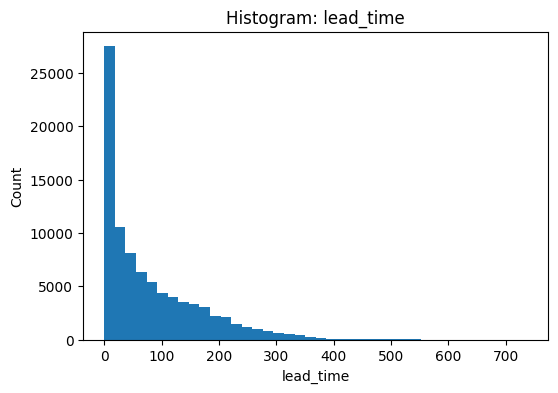

Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\hist_adr.png


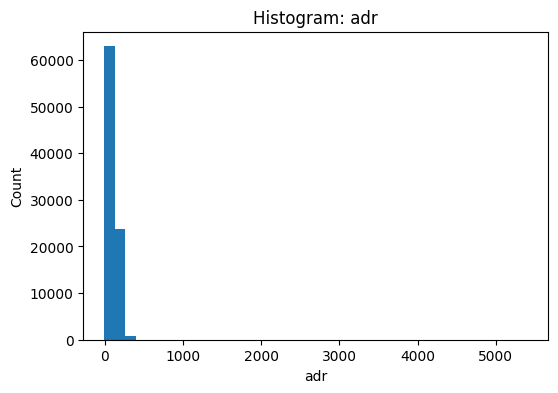

Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\hist_total_nights.png


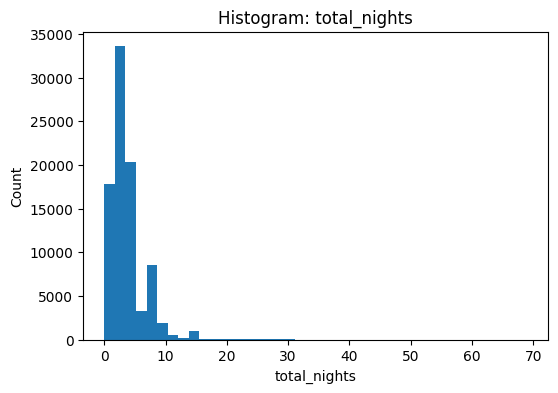

In [45]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_desc = df[numeric_cols].describe().T
save_dataframe(numeric_desc, ART["data"] / "numeric_describe.csv", index=True)
print("Saved:", (ART["data"] / "numeric_describe.csv").resolve())

display(numeric_desc.head(12))

df_eda = df.copy()
if {"stays_in_weekend_nights", "stays_in_week_nights"}.issubset(df_eda.columns):
    df_eda["total_nights"] = df_eda["stays_in_weekend_nights"].fillna(0) + df_eda["stays_in_week_nights"].fillna(0)

def plot_hist(series: pd.Series, title: str, filename: str, bins: int = 40):
    s = pd.to_numeric(series, errors="coerce").dropna()
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(s, bins=bins)
    ax.set_title(title)
    ax.set_xlabel(series.name)
    ax.set_ylabel("Count")
    out = ART["plots"] / filename
    fig.savefig(out, dpi=FIG_DPI, bbox_inches="tight")
    print("Saved:", out.resolve())
    plt.show()
    plt.close(fig)

for col, fname in [
    ("lead_time", "hist_lead_time.png"),
    ("adr", "hist_adr.png"),
    ("total_nights", "hist_total_nights.png"),
]:
    if col in df_eda.columns:
        plot_hist(df_eda[col], f"Histogram: {col}", fname)


## Categorical feature summary (top values)

Top categories (frequency) are saved to `artifacts/data/categorical_top_values.csv`.
A progress bar is used because this operation iterates across multiple columns.


In [46]:
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

rows = []
for c in tqdm(cat_cols, desc="Computing top categories"):
    vc = df[c].astype(str).value_counts(dropna=False).head(10)
    for k, v in vc.items():
        rows.append({"column": c, "value": k, "count": int(v), "rate": float(v / len(df))})

cat_top = pd.DataFrame(rows)
save_dataframe(cat_top, ART["data"] / "categorical_top_values.csv", index=False)
print("Saved:", (ART["data"] / "categorical_top_values.csv").resolve())

display(cat_top.head(25))


Computing top categories: 100%|██████████| 12/12 [00:00<00:00, 168.22it/s]

Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\data\categorical_top_values.csv


,column,value,count,rate
0,hotel,City Hotel,53428,0.611332
1,hotel,Resort Hotel,33968,0.388668
2,arrival_date_month,August,11257,0.128805
3,arrival_date_month,July,10057,0.115074
4,arrival_date_month,May,8355,0.095599
5,arrival_date_month,April,7908,0.090485
6,arrival_date_month,June,7765,0.088848
7,arrival_date_month,March,7513,0.085965
8,arrival_date_month,October,6934,0.079340
9,arrival_date_month,September,6690,0.076548


## Cancellation rate by key categorical groups

Cancellation rate is computed as the mean of `is_canceled` within each group.
Tables are saved to `artifacts/data/` and plots are saved to `artifacts/plots/`.


Group cancellation-rate plots:   0%|          | 0/4 [00:00<?, ?it/s]

Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\data\target_by_group_hotel.csv
Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\cancel_rate_by_hotel.png


,hotel,count,cancel_rate
0,City Hotel,53428,0.300386
1,Resort Hotel,33968,0.234809


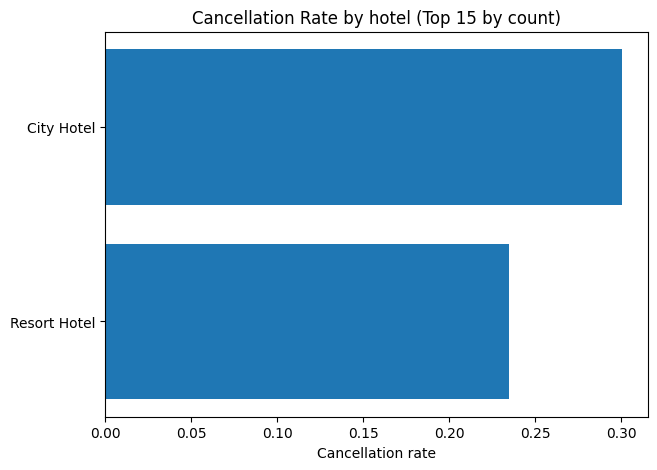

Group cancellation-rate plots:  25%|██▌       | 1/4 [00:00<00:00,  3.31it/s]

Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\data\target_by_group_deposit_type.csv
Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\cancel_rate_by_deposit_type.png


,deposit_type,count,cancel_rate
0,No Deposit,86251,0.266849
1,Non Refund,1038,0.947013
2,Refundable,107,0.242991


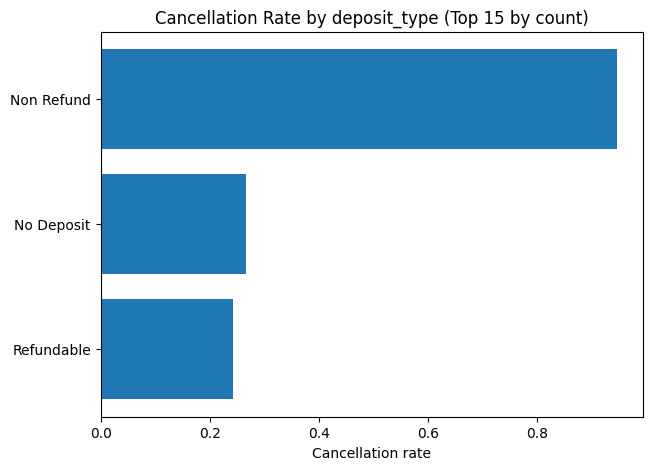

Group cancellation-rate plots:  50%|█████     | 2/4 [00:00<00:00,  3.34it/s]

Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\data\target_by_group_customer_type.csv
Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\cancel_rate_by_customer_type.png


,customer_type,count,cancel_rate
0,Transient,71986,0.301059
1,Transient-Party,11727,0.152383
2,Contract,3139,0.163109
3,Group,544,0.099265


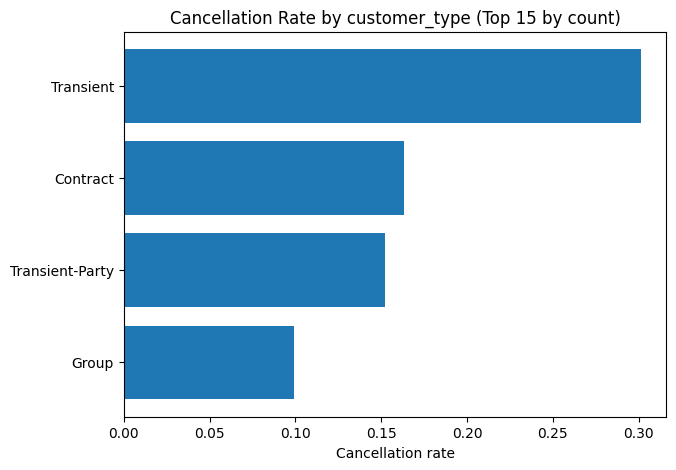

Group cancellation-rate plots:  75%|███████▌  | 3/4 [00:00<00:00,  3.13it/s]

Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\data\target_by_group_market_segment.csv
Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\cancel_rate_by_market_segment.png


,market_segment,count,cancel_rate
0,Online TA,51618,0.353462
1,Offline TA/TO,13889,0.148535
2,Direct,11804,0.147154
3,Groups,4942,0.270134
4,Corporate,4212,0.121083
5,Complementary,702,0.125356
6,Aviation,227,0.198238
7,Undefined,2,1.000000


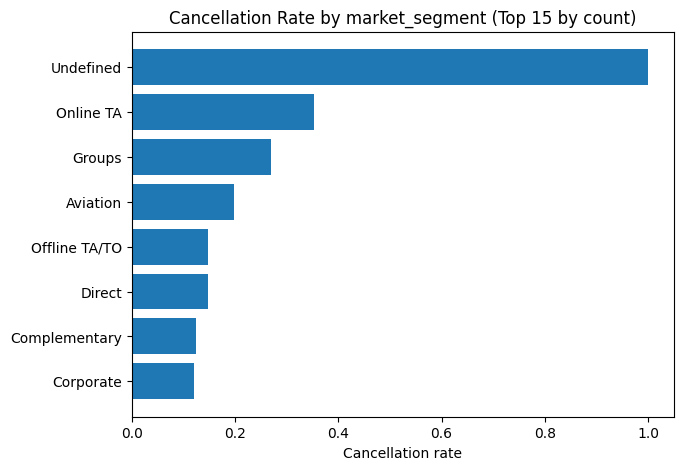

Group cancellation-rate plots: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]


In [47]:
def cancellation_rate_by(group_col: str, top_n: int = 15):
    if group_col not in df.columns:
        print(f"Skipped (column not found): {group_col}")
        return None

    tmp = df[[group_col, TARGET_COL]].copy()
    tmp[group_col] = tmp[group_col].astype(str)

    grp = (
        tmp.groupby(group_col)[TARGET_COL]
           .agg(["count", "mean"])
           .rename(columns={"mean": "cancel_rate"})
           .sort_values("count", ascending=False)
    )

    grp_top = grp.head(top_n).copy()
    out_csv = ART["data"] / f"target_by_group_{group_col}.csv"
    save_dataframe(grp_top.reset_index(), out_csv, index=False)

    grp_plot = grp_top.sort_values("cancel_rate", ascending=True)
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.barh(grp_plot.index, grp_plot["cancel_rate"])
    ax.set_title(f"Cancellation Rate by {group_col} (Top {top_n} by count)")
    ax.set_xlabel("Cancellation rate")

    out_fig = ART["plots"] / f"cancel_rate_by_{group_col}.png"
    fig.savefig(out_fig, dpi=FIG_DPI, bbox_inches="tight")

    print("Saved:", out_csv.resolve())
    print("Saved:", out_fig.resolve())

    display(grp_top.reset_index())
    plt.show()
    plt.close(fig)

    return grp_top.reset_index()

group_cols = ["hotel", "deposit_type", "customer_type", "market_segment"]
for col in tqdm(group_cols, desc="Group cancellation-rate plots"):
    cancellation_rate_by(col, top_n=15)


## Cancellation rate by arrival month

Arrival month is stored as a string (`arrival_date_month`).
A consistent month ordering is applied for plotting.


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\data\cancel_rate_by_arrival_month.csv
Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\cancel_rate_by_arrival_month.png


,month_num,is_canceled,month_name
0,1,0.221180,January
1,2,0.232043,February
2,3,0.243578,March
3,4,0.304628,April
4,5,0.292280,May
5,6,0.303155,June
6,7,0.317987,July
7,8,0.321844,August
8,9,0.245441,September
9,10,0.236804,October


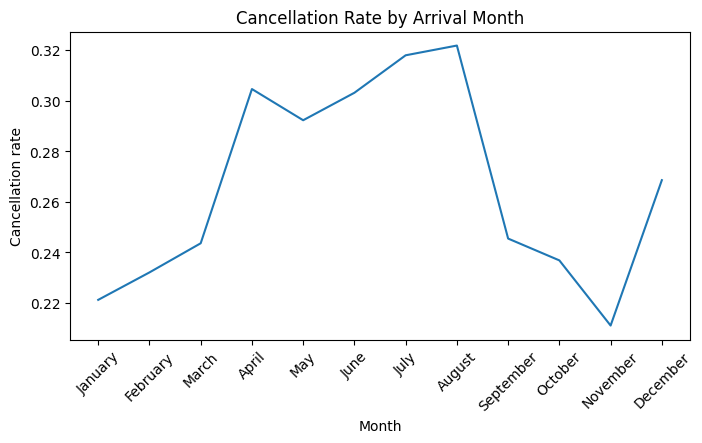

In [48]:
month_map = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}

if "arrival_date_month" in df.columns:
    tmp = df[["arrival_date_month", TARGET_COL]].copy()
    tmp["month_num"] = tmp["arrival_date_month"].map(month_map)

    grp = tmp.groupby("month_num")[TARGET_COL].mean().reset_index()
    grp["month_name"] = grp["month_num"].map({v: k for k, v in month_map.items()})
    grp = grp.sort_values("month_num")

    save_dataframe(grp, ART["data"] / "cancel_rate_by_arrival_month.csv", index=False)
    print("Saved:", (ART["data"] / "cancel_rate_by_arrival_month.csv").resolve())

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(grp["month_name"], grp[TARGET_COL])
    ax.set_title("Cancellation Rate by Arrival Month")
    ax.set_xlabel("Month")
    ax.set_ylabel("Cancellation rate")
    ax.tick_params(axis="x", rotation=45)

    out_path = ART["plots"] / "cancel_rate_by_arrival_month.png"
    fig.savefig(out_path, dpi=FIG_DPI, bbox_inches="tight")
    print("Saved:", out_path.resolve())

    display(grp)
    plt.show()
    plt.close(fig)
else:
    print("Skipped: arrival_date_month column not found")


## Numeric correlation

Pearson correlation is computed for numeric columns.
A correlation heatmap is displayed and saved for reporting support.


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\data\correlation_numeric.csv
Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\correlation_heatmap_numeric.png


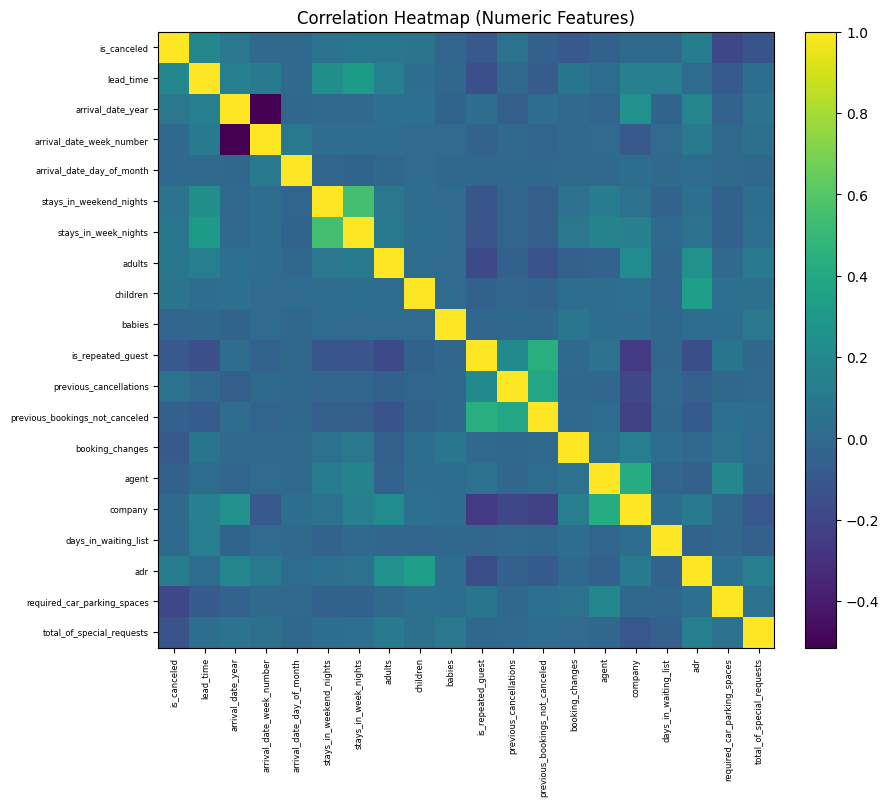

In [49]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr(numeric_only=True)
save_dataframe(corr, ART["data"] / "correlation_numeric.csv", index=True)
print("Saved:", (ART["data"] / "correlation_numeric.csv").resolve())

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr.values)
ax.set_title("Correlation Heatmap (Numeric Features)")

ax.set_xticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=6)
ax.set_yticks(range(len(corr.index)))
ax.set_yticklabels(corr.index, fontsize=6)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

out_path = ART["plots"] / "correlation_heatmap_numeric.png"
fig.savefig(out_path, dpi=FIG_DPI, bbox_inches="tight")
print("Saved:", out_path.resolve())

plt.show()
plt.close(fig)


## Report notes (EDA insights)

Bullet points are saved to `artifacts/reports/eda_insights.md`.
Replace placeholders with findings derived from the generated plots and tables.


In [50]:
eda_insights = [
    "- Target distribution: report the cancellation rate and whether class balance is skewed.",
    "- Highest missing-rate columns: list the top columns and propose imputation strategies.",
    "- Strongest categorical patterns: summarize influential group differences (hotel, deposit type, segment).",
    "- Numeric distributions: describe skewness/outliers for lead_time and adr; justify clipping/robust preprocessing.",
    "- Seasonality: summarize changes in cancellation rate across arrival months.",
    "- Data quality notes: document suspicious values and handling decisions.",
    "- Preprocessing plan: median imputation for numeric, most_frequent for categorical, one-hot encoding for categoricals.",
    "- Scaling policy: required for KNN/LogReg; not required for Tree/RF.",
]

out_path = ART["reports"] / "eda_insights.md"
save_text("\n".join(eda_insights), out_path)
print("Saved:", out_path.resolve())

display(pd.DataFrame({"EDA insights (edit for report)": eda_insights}))


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\reports\eda_insights.md


,EDA insights (edit for report)
0,- Target distribution: report the cancellation...
1,- Highest missing-rate columns: list the top c...
2,- Strongest categorical patterns: summarize in...
3,- Numeric distributions: describe skewness/out...
4,- Seasonality: summarize changes in cancellati...
5,- Data quality notes: document suspicious valu...
6,- Preprocessing plan: median imputation for nu...
7,- Scaling policy: required for KNN/LogReg; not...


## Next notebook

Proceed to `02_preprocessing_pipeline.ipynb` to build the preprocessing pipelines used by all models.
